In [1]:
import pandas as pd
# from sklearn.ensemble
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def readFile(filename):
    f = pd.read_csv(f'./_data/{filename}.csv')
    return f

def ACCURACY(true, pred):
    score = np.mean(true==pred)
    return score

def z_oForType(data,columnName):
    columns = set(data[columnName].values)
    colNames = {}
    for key, value in enumerate(columns):
        colNames[value] = key
    data[columnName] = data[columnName].map(lambda x: colNames[x])
    #data[columnName] = data[columnName].replace(colNames) 로 해도 된답니다.
    return data

In [2]:
train_data = readFile('train')      #[3231 rows x 14 columns]
train_data = z_oForType(train_data, 'type')

#print(train_data)
test_data = readFile('test')
test_data = z_oForType(test_data, 'type')

# 결측치 확인
# print(f"train_data의 결측치:")
# print(f"{train_data.isna().sum()}")
# print("-"*30)
# print(f"test_data 결측치:")
# print(f"{test_data.isna().sum()}")
# print("-"*30)

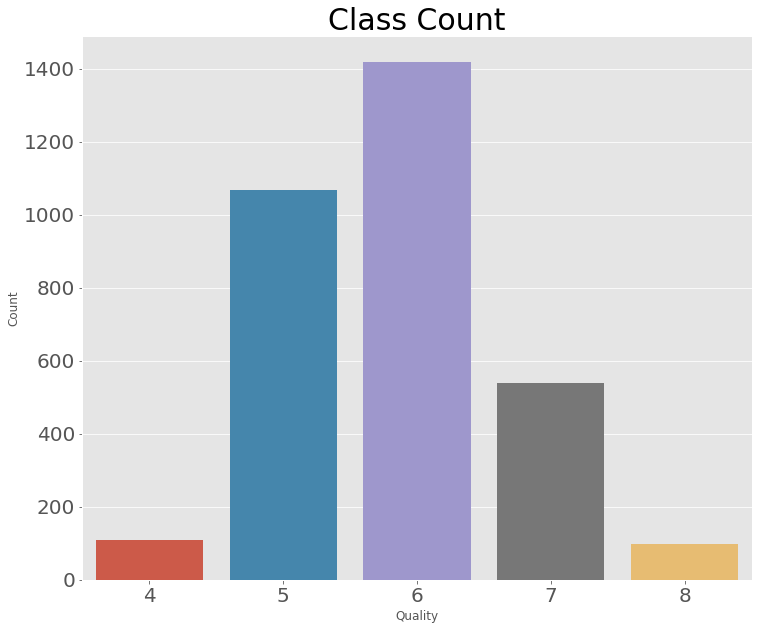

In [3]:
#     특정 클래스 데이터가 치우쳐 있는지 확인하고 데이터를 추가 등의 계획 수립
#     클래스 분포 확인. 4~8등의 와인이 있고 대부분의 데이터가 5~6에 치우쳐 있음
counted_values = train_data['quality'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
plt.title('Class Count', fontsize=30)
    
value_bar_ax = sns.barplot(x=counted_values.index, y=counted_values)
value_bar_ax.tick_params(labelsize=20)
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

In [9]:
y_train

0       6
1       7
2       6
3       5
4       7
       ..
3226    5
3227    6
3228    5
3229    6
3230    7
Name: quality, Length: 3231, dtype: int64

In [33]:
from collections import Counter

X_train = train_data.drop(columns=['id', 'quality'])
y_train = train_data['quality']

X_test = test_data.drop(columns=['id'])
print(sorted(Counter(y_train).items()))

[(4, 108), (5, 1069), (6, 1418), (7, 539), (8, 97)]


In [32]:
# 다운 샘플링
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(4, 97), (5, 97), (6, 97), (7, 97), (8, 97)]


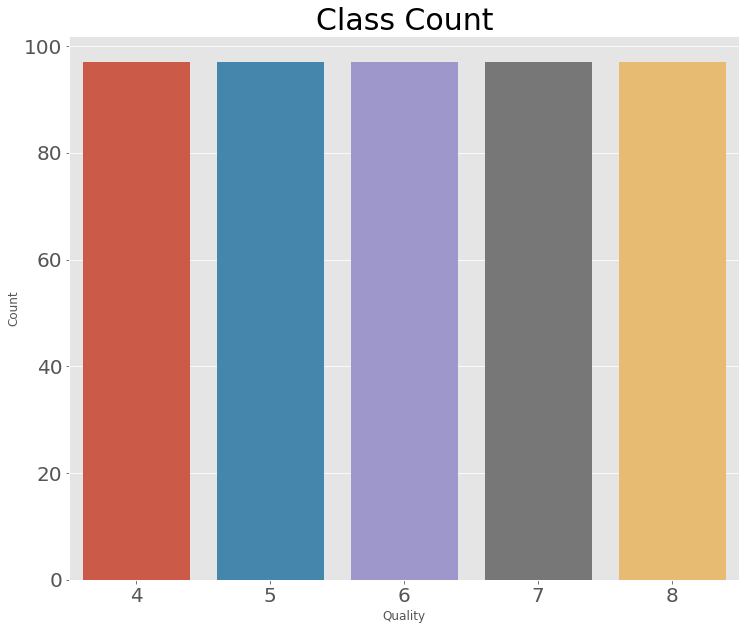

In [34]:
# 그래프로 데이터 확인
counted_values = y_resampled.value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
plt.title('Class Count', fontsize=30)
    
value_bar_ax = sns.barplot(x=counted_values.index, y=counted_values)
value_bar_ax.tick_params(labelsize=20)
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

In [39]:
#리샘플링 한 데이터로 훈련
from sklearn.model_selection import train_test_split
X_train_resample,  X_test_resample, y_train_resample, y_test_resample = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)

from sklearn.ensemble import RandomForestClassifier
forest_resample = RandomForestClassifier(n_estimators=500, random_state=1)
forest_resample.fit(X_train_resample, y_train_resample)

RandomForestClassifier(n_estimators=500, random_state=1)

In [40]:
# RFE를 사용하여 우선순위가 높은 특성 5개를 선택하여 훈련
from sklearn.feature_selection import RFE
rfe = RFE(forest_resample, n_features_to_select=5)
rfe.fit(X_train_resample, y_train_resample)
#print(rfe.ranking_)     # 선택한 특성의 우선순위 저장 --> 모델이 선택한 특성은 1로 나타냄
f_mask = rfe.support_
importances_resample = rfe.estimator_.feature_importances_
indices = np.argsort(importances_resample)[::-1]

for i in indices:
    print(f"{i+1:2d} {' '*5} {feat_labels[f_mask][i]} {' '*5} {importances_resample[i]}")
    
prediction = forest_resample.predict(X_test_resample)
score = ACCURACY(y_test_resample, prediction)
print(f'모델의 정확도: {score*100:.2f}%')

 5       alcohol       0.26261118603800293
 1       volatile acidity       0.22859228522575076
 3       pH       0.17177100699176512
 4       sulphates       0.1707735617443539
 2       chlorides       0.16625196000012726
모델의 정확도: 60.96%


In [ ]:
#     prediction = forest_resample.predict(X_test)
#     print(prediction)
#     submission = pd.read_csv('./_data/sample_submission.csv')
#     submission['quality'] = prediction
#     submission.to_csv("./_data/output/submission(feature=5).csv", index=False)

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svc =  SVC(kernel='rbf', random_state=1, gamma=0.3, C=2.0)
pipe_svc = make_pipeline(StandardScaler(), svc)
param_range = [0.1,1.0,10.0,100.0,1000.0,10000.0]
distribution = loguniform(0.0001,1000.0) #샘플링 가능한 분포 지정 :로그균등분포
param_dist = [{'svc__C': param_range,'svc__kernel':['linear']},
             {'svc__C':param_range, 'svc__gamma':param_range, 'svc__kernel':['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_dist, n_iter=30, cv=10, random_state=1, n_jobs=-1)
rs = rs.fit(X_train_resample,y_train_resample)
print(rs.best_params_)
print(rs.best_score_)

{'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 1000.0}
0.6666666666666667


In [ ]:
#역시 데이터 다운샘플은... 성능저하 
#데이터가 부족한가.. 불려보자